The goal of this analysis is to determine if there is a correlation between genre tags and user suggestions.

This analysis will limit the number of tags in the dataset to 5.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MultiLabelBinarizer

In [3]:
df_test = pd.read_csv("../Data/test_gr/test.csv")
df_train = pd.read_csv("../Data/train_gr/train.csv")
df_overview = pd.read_csv("../Data/train_gr/game_overview.csv")

In [4]:
#group training data by title and aggregate the mean of the user_suggestion
d = df_train.groupby([df_train["title"]], as_index=False).agg({"user_suggestion": "mean"}).sort_values(by="user_suggestion", ascending=False)

In [5]:
#join the training and overview data into an array
df_join = [d, df_overview]
#convert array into data frame
df_join = pd.concat(df_join)

#group by title and ensure that other relevant columns are preserved. Everything else is dropped
df_join = df_join.groupby(["title"]).agg({"user_suggestion": "mean", "tags": "first"}).reset_index().sort_values(by="user_suggestion", ascending=False)
df_join.head()

,title,user_suggestion,tags
20,EverQuest II,0.971014,"['Free to Play', 'Massively Multiplayer', 'RPG..."
23,Fractured Space,0.958217,"['Space', 'Multiplayer', 'Free to Play', 'PvP'..."
34,Path of Exile,0.906114,"['Free to Play', 'Action RPG', 'Hack and Slash..."
9,Creativerse,0.900407,"['Free to Play', 'Survival', 'Open World', 'Mu..."
35,PlanetSide 2,0.896186,"['Free to Play', 'Massively Multiplayer', 'FPS..."


In [6]:
#get games with nan user_suggestion values
df_nan = df_join[~(df_join["user_suggestion"] <= 1)]
df_nan_encoded = df_join[~(df_join["user_suggestion"] <= 1)]

#copy dataframe without encoded titles
df_final = df_join.copy(deep=True)
#copy dataframe with encoded titles (eventually)
df_encoded = df_join.copy(deep=True)

#drop nan values from copied dataframes
df_final = df_final.dropna()
df_encoded = df_encoded.dropna()

In [7]:
#encode titles to numeric values in df_encoded
le = LabelEncoder()
oe = OrdinalEncoder().set_output(transform="pandas")
df_encoded["title"] = le.fit_transform(df_encoded["title"])
df_nan_encoded["title"] = le.fit_transform(df_nan_encoded["title"])
df_encoded.head()

C:\Users\dylan\AppData\Local\Temp\ipykernel_9732\2187266266.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan_encoded["title"] = le.fit_transform(df_nan_encoded["title"])


,title,user_suggestion,tags
20,14,0.971014,"['Free to Play', 'Massively Multiplayer', 'RPG..."
23,16,0.958217,"['Space', 'Multiplayer', 'Free to Play', 'PvP'..."
34,21,0.906114,"['Free to Play', 'Action RPG', 'Hack and Slash..."
9,6,0.900407,"['Free to Play', 'Survival', 'Open World', 'Mu..."
35,22,0.896186,"['Free to Play', 'Massively Multiplayer', 'FPS..."


In [8]:
#make a dataframe with the tags as one big string
final_str = df_final.copy(deep=True)
encoded_str = df_encoded.copy(deep=True)

for i, row in df_final["tags"].items():
    df = row.replace("[", "").replace("]", "").replace("'", "")
    df = df.split(", ")[:5]
    
    #make tags an array of strings
    df_final["tags"][i] = df
    df_encoded["tags"][i] = df

    #make tags one big string
    final_str["tags"][i] = ' '.join(df)
    encoded_str["tags"][i] = ' '.join(df)


C:\Users\dylan\AppData\Local\Temp\ipykernel_9732\3153138693.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded["tags"][i] = df
C:\Users\dylan\AppData\Local\Temp\ipykernel_9732\3153138693.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_str["tags"][i] = ' '.join(df)
C:\Users\dylan\AppData\Local\Temp\ipykernel_9732\3153138693.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_str["tags"][i] = ' '.join(df)

In [9]:
genre = []
#iterate through tags column and concat into a single dataframe
for i, row in df_encoded["tags"].items():
    for x in row:
        genre.append(x)
df_genre = pd.DataFrame(data={"genre": genre})
df_genre.head()

,genre
0,Free to Play
1,Massively Multiplayer
2,RPG
3,MMORPG
4,Fantasy


In [10]:
df_genre["titles"] = 0
df_genre["user_suggestions"] = 0

#match each genre with a list of titles/user_suggestions that has that tag
for i, row in df_genre.iterrows():
    for x, r in df_encoded.iterrows():
        if row["genre"] in r["tags"]:
            df_genre["titles"][i] += 1
            df_genre["user_suggestions"][i] += df_encoded["user_suggestion"][x]
df_genre.head()

C:\Users\dylan\AppData\Local\Temp\ipykernel_9732\3359241191.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre["titles"][i] += 1
C:\Users\dylan\AppData\Local\Temp\ipykernel_9732\3359241191.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre["user_suggestions"][i] += df_encoded["user_suggestion"][x]
C:\Users\dylan\AppData\Local\Temp\ipykernel_9732\3359241191.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9710144927536232' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_genre["user

,genre,titles,user_suggestions
0,Free to Play,43,27.157581
1,Massively Multiplayer,11,6.729843
2,RPG,10,7.345771
3,MMORPG,5,3.012079
4,Fantasy,1,0.971014


In [11]:
#get the mean of the user_suggestions
for x, row in df_genre.iterrows():
    df_genre["user_suggestions"][x] = df_genre["user_suggestions"][x] / df_genre["titles"][x]
df_genre = df_genre.drop_duplicates()

In [12]:
df_genre

,genre,titles,user_suggestions
0,Free to Play,43,0.631572
1,Massively Multiplayer,11,0.611804
2,RPG,10,0.734577
3,MMORPG,5,0.602416
4,Fantasy,1,0.971014
...,...,...,...
181,Hunting,1,0.444015
186,Tower Defense,1,0.412017
195,Zombies,1,0.269311
214,War,1,0.110067


In [13]:
df_genre["genre"] = le.fit_transform(df_genre["genre"])

In [14]:
x = df_genre["genre"]
y = df_genre["user_suggestions"]

In [15]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.30, random_state=1)

In [16]:
from sklearn.linear_model import LinearRegression


lin_reg = LinearRegression()
lin_reg.fit(x_train.to_numpy().reshape(-1, 1),y_train)

LinearRegression()

In [17]:
print('Coefficients:', lin_reg.coef_)
print('Intercept', lin_reg.intercept_)

Coefficients: [-0.00201048]
Intercept 0.717339194836736


In [18]:
y_pred = lin_reg.predict(x_test.to_numpy().reshape(-1, 1))
y_pred

array([0.70326582, 0.60475221, 0.7052763 , 0.62887799, 0.63289895,
       0.60274173, 0.67109811, 0.71733919, 0.69522389, 0.62284654,
       0.66908763, 0.63691992, 0.59268932, 0.62083606, 0.71532871,
       0.62686751, 0.70929727, 0.65300377, 0.69120293, 0.70125534])

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

print("MSE: %.2f" % mean_squared_error(y_test, y_pred))

MSE: 0.03


In [20]:
print("R2 Score (Coefficient of Determination): %.2f" % r2_score(y_test, y_pred))

R2 Score (Coefficient of Determination): 0.09


In [21]:
y_pred

array([0.70326582, 0.60475221, 0.7052763 , 0.62887799, 0.63289895,
       0.60274173, 0.67109811, 0.71733919, 0.69522389, 0.62284654,
       0.66908763, 0.63691992, 0.59268932, 0.62083606, 0.71532871,
       0.62686751, 0.70929727, 0.65300377, 0.69120293, 0.70125534])

<Axes: xlabel='genre', ylabel='user_suggestions'>

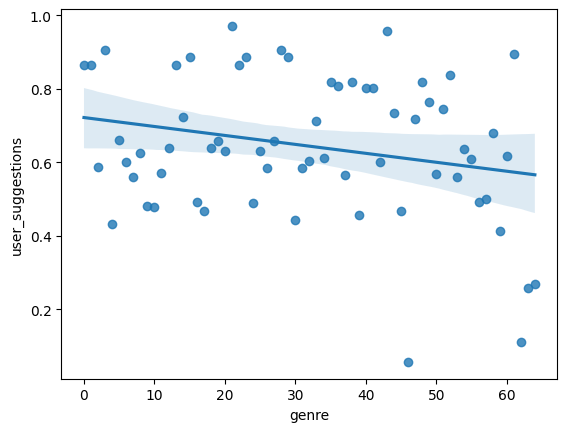

In [22]:
sns.regplot(data=df_genre, y='user_suggestions',x="genre")

Linear Regression: 0 to predict user suggestion averages
R2 Score (Coefficient of Determination): -0.00
MSE: 0.05
--------------------------------------------------------------------------------
Linear Regression: 1 to predict user suggestion averages
R2 Score (Coefficient of Determination): -0.48
MSE: 0.04
--------------------------------------------------------------------------------
Linear Regression: 2 to predict user suggestion averages
R2 Score (Coefficient of Determination): 0.05
MSE: 0.04
--------------------------------------------------------------------------------
Linear Regression: 3 to predict user suggestion averages
R2 Score (Coefficient of Determination): -0.27
MSE: 0.04
--------------------------------------------------------------------------------
Linear Regression: 4 to predict user suggestion averages
R2 Score (Coefficient of Determination): 0.07
MSE: 0.03
--------------------------------------------------------------------------------


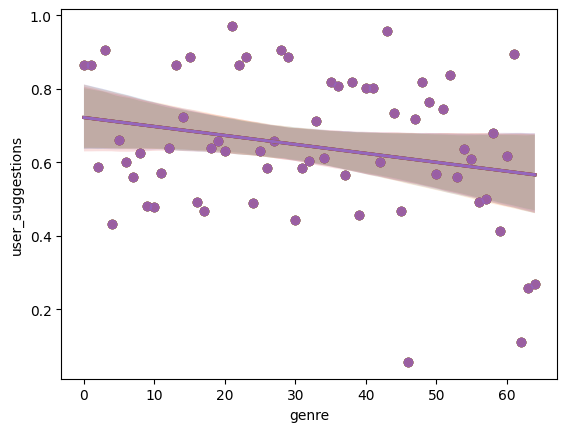

In [23]:
for f in range(0, 5):
    x = df_genre["genre"]
    y = df_genre["user_suggestions"]

    # Train-Test Split
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20)

    # Create and fit the Linear Regression Model.
    lin_reg = LinearRegression()
    lin_reg.fit(x_train.to_numpy().reshape(-1, 1),y_train)

    # Predict using the 'test' values.
    y_pred = lin_reg.predict(x_test.to_numpy().reshape(-1, 1))

    print(f'Linear Regression: {f} to predict user suggestion averages')
    print("R2 Score (Coefficient of Determination): %.2f" % r2_score(y_test, y_pred))
    print("MSE: %.2f" % mean_squared_error(y_test, y_pred))
    sns.regplot(data=df_genre, y='user_suggestions',x="genre")
    print('-'*80)


<Axes: xlabel='genre', ylabel='titles'>

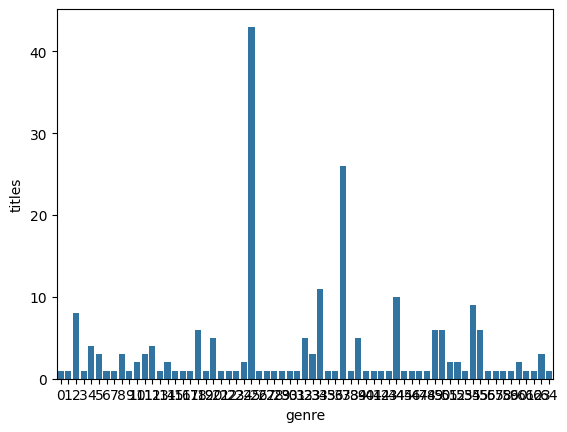

In [24]:
sns.barplot(data=df_genre, x="genre", y="titles")

In [25]:
len(df_encoded)

44

In [26]:
len(df_genre)

65